<a href="https://colab.research.google.com/github/DeBrandy/machine_learning/blob/main/thompson_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
stationary = True
class Bandit():
  """
  多臂老虎机
  初始化每个臂的分布（均匀分布）：被选择的概率
  获取regret（loss）
  """
  def __init__(self, arm_count):
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary = stationary
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)  #label:实际上每个臂被选择的概率/每个臂被选择的奖励
  def get_reward_regret(self,arm): #这里是每次只拉一个臂，也可以一次拉多个臂
    self.timestep += 1
    #模拟伯努利采样
    sim = np.random.uniform(0,1,self.arm_count) #训练中，每轮每个臂被选择的概率/奖励（对应情况：用户是否点击）
    rewards = (sim<self.thetas).astype(int)  #模拟的奖励<实际奖励，记为1（我们估计的奖励太低了，要提高），大于记为0。虽然有的臂没被选中，但一起算了奖励，后面没要它们
    #在实际的展点中，通过get_action估计每个item的ctr，选择最高的展示，用户点击就给alpha+1，没点给beta+1
    reward = rewards[arm]  #可读多个臂，只读被选中的臂
    regret = self.thetas.max() - self.thetas[arm]  #实际上的最大奖励-选择当前臂的奖励=loss
    return reward, regret

In [7]:
class BetaAlgo:
  """
  假设每个臂的概率分布为beta分布
  （假设真实分布为Bernoulli分布，如Bandit中generate_thetas）
  """
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)

  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._updata_params(arm, reward)
    return reward, regret

  def _updata_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1-reward

class Thompson(BetaAlgo):
  def __init_(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'

  def get_action(self):
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [6]:
def plot_data(y):
  x = np.arange(y.size())
  _ = plt.plot(x,y,'o')
def multi_plot_data(data, names):
  x = np.arange(data[0].size)
  for i,y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()

In [13]:
def simulate(simulations, timesteps, arm_count, Algorithm): #模拟训练过程
  sum_regrets = np.zeros(timesteps) #各个step在simulations（epoch）轮后，regret总和
  for epoch in range(simulations):
    bandit = Bandit(arm_count) #每一个epoch都重新初始化老虎机的每个臂
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps) #timesteps(训练的step)，本epoch的regret
    for i in range(timesteps):
      action = algo.get_action()  #根据beta分布生成的选择概率，返回最大的臂
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret  #当前step的loss
    sum_regrets += regrets
  mean_regrets = sum_regrets / simulations
  return mean_regrets


In [21]:
def experiment(arm_count,timesteps=1000,simulations=1000):
  algos = [Thompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

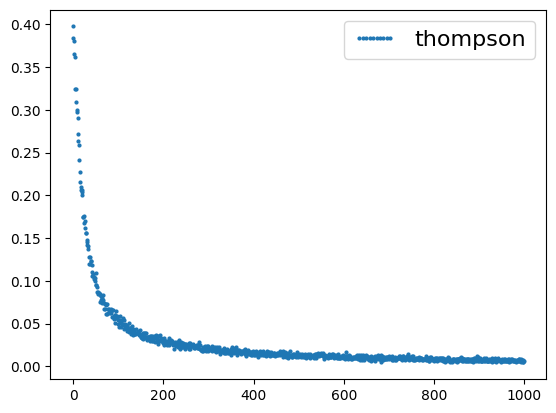

In [22]:
arm_count = 10
stationary=True
experiment(arm_count)